<a href="https://colab.research.google.com/github/spacesys-finch/destriping/blob/Rishit-dagli-mixup/destriping/augmentation_pipeline/cutmix_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

_mixup_ is a *domain-agnostic* data augmentation technique proposed in [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412) by Zhang et al.

(The lambda hyperparameter values are values with the [0, 1] range and are sampled from the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).)

The technique is quite systematically named. We are literally mixing up the features and their corresponding labels. Implementation-wise it's simple. Neural networks are prone to [memorizing corrupt labels](https://arxiv.org/abs/1611.03530). mixup relaxes this by combining different features with one another (same happens for the labels too) so that a network does not get overconfident about the relationship between the features and their labels.

mixup is specifically useful when we are not sure about selecting a set of augmentation transforms for a given dataset, and is especially useful for image data.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

## Load the CIFAR-10 dataset

In this example, we will use the
[CIFAR-10 image classification dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

170498071/170498071 [==============================] - 5s 0us/step
(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


## Define hyperparameters

In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 32

## Convert the data into TensorFlow `Dataset` objects

In [5]:
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Define the MixUp data augmentation function

The CutMix function takes two `image` and `label` pairs to perform the augmentation. It samples `λ(l)` from the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) and returns a bounding box from `get_box` function. We then crop the second image (`image2`) and pad this image in the final padded image at the same location.

In [6]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

**Note**: we are combining two images to create a single one.

## Visualize the new dataset after applying the MixUp augmentation

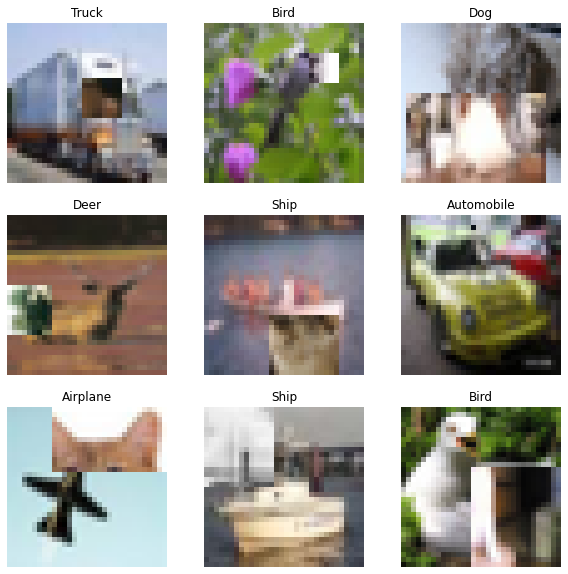

In [7]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")